In [33]:
import os
import torch
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import IPython
from tqdm import tqdm

# 数据生成
from scipy import stats
from fitter import Fitter

from Process_Data.audio_processing import read_WaveInt
from Define_Model.model import create_model, load_model_args, create_classifier
from Define_Model.SoftmaxLoss import AdditiveMarginLinear

In [63]:
from Process_Data.Datasets.SelectDataset import cost_func
from geomloss import SamplesLoss


In [16]:
import torch.nn.functional as F

In [2]:
lstm_path = '/home/yangwenhao/project/lstm_speaker_verification'
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch'

In [3]:
model_dir = 'ECAPA_brain/Mean_batch48_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_mix/1234'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir
check_yaml = check_path + '/model.2024.03.15.yaml'

In [4]:
model_kwargs = load_model_args(check_yaml)
if 'embedding_model' in model_kwargs:
    model = model_kwargs['embedding_model']
    if 'classifier' in model_kwargs:
        model.classifier = model_kwargs['classifier']
# model.classifier = AdditiveMarginLinear
create_classifier(model, **model_kwargs)

In [5]:
resume_path = check_path + '/checkpoint_{}.pth'
# ep = 24 # Load model from Checkpoint file
ep = 'avg3' # Load model from Checkpoint file

if os.path.isfile(resume_path.format(ep)):
    checkpoint = torch.load(resume_path.format(ep))
    checkpoint_state_dict = checkpoint['state_dict']
    if isinstance(checkpoint_state_dict, tuple):
        checkpoint_state_dict = checkpoint_state_dict[0]

    filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
    if list(filtered.keys())[0].startswith('module'):
        new_state_dict = OrderedDict()
        for k, v in filtered.items():
            name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
            new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。
        model.load_state_dict(new_state_dict)
    else:
        model_dict = model.state_dict()
        model_dict.update(filtered)
        model.load_state_dict(model_dict)

In [6]:
model = model.eval()

#### Data loaders

In [52]:
audio_uids = []
total_utts = 2000

np.random.seed(1234)
with open('/home/yangwenhao/project/lstm_speaker_verification/data/vox1/dev/wav.scp', 'r') as f:
    for l in tqdm(f.readlines(), ncols=50):
        if np.random.uniform(0,1) <= 0.2:
            uid, upath = l.split()
            wav, sr = sf.read(upath)
            dur = float(len(wav)/sr)

            if dur >= 6 :
                # uid[7] = '/'
                # uid[-6] = '/'
                uid_path = '/'.join(upath.split('/')[-3:])[:-4]
                # uid_path = uid.replace('-', '/')
                # id10270-5r0dWxy17C8-00010
                audio_uids.append(uid_path)

            if len(audio_uids) >= total_utts:
                break

 12%|▍   | 18189/148642 [00:13<01:36, 1356.84it/s]


In [ ]:
audios = []

common_path = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_dev_wav'
duration = 32000

for uid in tqdm(audio_uids, ncols=50):
    # upath = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav/{}.wav'.format(uid)
    # upath_radio_dist0 = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav_radchn2/{}.wav'.format(uid)
    upath = '{}/wav/{}.wav'.format(common_path, uid)
    upath_radio = '{}/wav_nb_radsnr1/{}.wav'.format(common_path, uid)
    
    paths = [upath, upath_radio]
    paths.extend(['{}/{}/{}.wav'.format(common_path, s, uid) for s in \
                  ['wav_nb_randsnr0', 'wav_nb_radsnr05', 'wav_nb_randsnr2', 'wav_nb_randsnr5', ]])
    this_audio = [torch.tensor(read_WaveInt(paths[0],
                                  start=20000, stop=20000+duration)).reshape(1,1,-1)]
    for u in paths[1:]:
        this_audio.append(torch.tensor(read_WaveInt(u,
                                  start=16000, stop=16000+duration)).reshape(1,1,-1))

    audios.append(torch.cat(this_audio, dim=0))

  8%|▊         | 155/2000 [02:39<16:06,  1.91it/s]

### feature mappings

In [149]:
torch.cuda.set_device(1)
device = 'cuda:1'

fms = []

model = model.cuda()
with torch.no_grad():
    for x in tqdm(audios, ncols=50):
        fb_x = model.input_mask(x.cuda())
        if len(fb_x.shape) == 4:
            fb_x = fb_x.squeeze(1).float()
        fb_x = fb_x.transpose(1, 2)

        x1 = model.blocks[0](fb_x)
        x2 = model.blocks[1](x1)
        x3 = model.blocks[2](x2)
        x4 = model.blocks[3](x3)
        
        # xs.append(torch.stack([x1, x2, x3, x4,]))
        x5 = torch.cat([x2, x3, x4], dim=1)
        x6 = model.mfa(x5)
        x7 = model.asp(x6, lengths=None)
        x8 = model.asp_bn(x7)
        
        embeddings = model.fc(x8)
        
        fms.append([x1.detach().cpu(), x2.detach().cpu(), x3.detach().cpu(),
                    x4.detach().cpu(), x5.detach().cpu(), x6.detach().cpu(),
                    x7.detach().cpu(), x8.detach().cpu(), embeddings.detach().cpu()])
        
# xs = torch.stack(xs)

100%|█████████| 8000/8000 [02:02<00:00, 65.45it/s]


#### distance function

In [134]:
akld_fn = lambda a,b: (torch.log((a.std(dim=0)+1e-6)/(b.std(dim=0)+1e-6)) + (a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2)/(2*b.var(dim=0)+1e-6) - 0.5).mean()

#### akld from IBN-Net

In [141]:
def kld_fn(a, b):
    a = a.reshape(-1, a.shape[1])
    b = b.reshape(-1, b.shape[1])
    return (torch.log((a.std(dim=0)+1e-6)/(b.std(dim=0)+1e-6)) + (a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2)/(2*b.var(dim=0)+1e-6) - 0.5).mean()

akld_fn = lambda a,b: kld_fn(a, b) + kld_fn(b, a)

In [96]:
kld(torch.randn(12,2,4), torch.randn(12,2,4)).mean()

tensor(0.1679)

#### KLD loss

In [62]:
kld_fn = torch.nn.KLDivLoss()
kld_dist_fn = lambda a,b: kld_fn(F.log_softmax(a, dim=1), F.softmax(b)) + kld_fn(F.log_softmax(b, dim=1), F.softmax(a))

In [98]:
akld_fn = lambda a,b: (torch.log(a.std(dim=0)/b.std(dim=0)) + a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2/(2*b.var(dim=0)) - 0.5).mean()

#### Sinkhorn distance

In [79]:
sinkhorn_fn = SamplesLoss("sinkhorn", p=2, blur=0.05, cost=lambda a, b: cost_func(a, b, p=2, metric='cosine'))
# opt_dist_fn = lambda a,b: sinkhorn_fn(a.transpose(0,1), b.transpose(0,1))
opt_dist_fn = lambda a,b: sinkhorn_fn(a, b)

In [11]:
fms[0][0].shape

torch.Size([2, 256, 401])

In [14]:
loss_fn(fms[0][0][0], fms[0][0][1])

/home/yangwenhao/anaconda3/envs/py38_torch12/lib/python3.8/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(-0.1222)

In [150]:
dist = []
dist_base = []

dist_fn = opt_dist_fn
batch_size = 200
# total_utts // batch_size

for i in tqdm(range(total_utts // batch_size), ncols=50):
    fm = fms[i*batch_size:(i+1)*batch_size]
    
    this_d = []
    this_bd = []
    
    for j in range(len(fm[0])):
        this_f = torch.stack([f[j] for f in fm], dim=0)
        f0 = this_f[:, 0].cuda()
        f1 = this_f[:, 1].cuda()
        
        # if len(f0.shape) >=3:
        #     f0 = f0.transpose_(0, 1).contiguous()
        #     f1 = f1.transpose_(0, 1).contiguous()
        
        idx = np.arange(len(f1))
        np.random.shuffle(idx)
        
        # print(f0.transpose(0,1).shape, f1.transpose(0,1).shape)
        l = float(dist_fn(f0, f1[idx]).mean())
        if np.isnan(l):
            print(i, j)
            
        this_d.append(l)
        
        idx = np.arange(len(f0))
        np.random.shuffle(idx)
        l = float(dist_fn(f0, f0[idx]).mean())
        this_bd.append(l)
        
        # print(l, f0.shape, f1.shape)
    dist.append(this_d)
    dist_base.append(this_bd)
    # break
        
# for fm in tqdm(fms, ncols=50):
#     dist.append([float(loss_fn(F.log_softmax(f[0].cuda(), dim=-1), F.softmax(f[1].cuda(), dim=-1)) + \
#                        loss_fn(F.log_softmax(f[1].cuda(), dim=-1), F.softmax(f[0].cuda(), dim=-1))) for f in fm])

100%|█████████████| 40/40 [03:31<00:00,  5.29s/it]


In [117]:
this_f = torch.stack([f[4] for f in fm], dim=0)

f0 = this_f[:, 0].cuda()
f1 = this_f[:, 1].cuda()

In [118]:
dist_fn(f0, f1[idx])

tensor(nan, device='cuda:1')

In [130]:
a = f0
b = f1[idx]

print(torch.log(((a.std(dim=0)+1e-6)/(b.std(dim=0)+1e-6))).mean())
print(((a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2)/(2*b.var(dim=0)+1e-6)).mean())

tensor(0.0786, device='cuda:1')
tensor(0.7334, device='cuda:1')


In [125]:
(a.std(dim=0)/b.std(dim=0)).min()

tensor(nan, device='cuda:1')

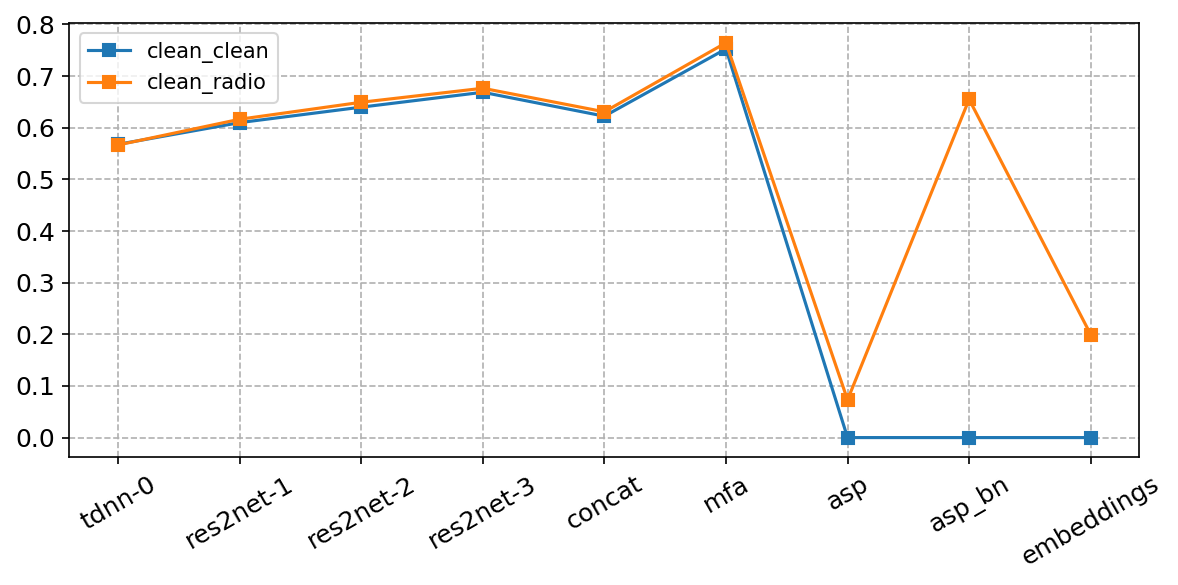

In [151]:
ticks_font = 12
plt.figure(figsize=(8,4), dpi=150)

#'tdnn-1', 
x = ['tdnn-0', 'res2net-1', 'res2net-2', 'res2net-3', 'concat', 'mfa', 'asp', 'asp_bn', 'embeddings',]

plt.plot(x, np.mean(dist_base, axis=0), marker='s')
plt.plot(x, np.mean(dist, axis=0), marker='s')

# plt.yscale('log')
plt.legend(['clean_clean', 'clean_radio'])
_=plt.xticks(fontsize=ticks_font, rotation=30)
_=plt.yticks(fontsize=ticks_font)
plt.grid(linestyle='--')
plt.tight_layout()

plt.savefig('imgs/opt_shuffle_radio_clean_{}_dev{}_batch{}.png'.format(train_set, total_utts, batch_size))

In [152]:
[1]*1+2

TypeError: can only concatenate list (not "int") to list

In [49]:
idx = np.arange(10)
np.random.shuffle(idx)

In [50]:
idx

array([2, 5, 7, 1, 4, 8, 6, 0, 9, 3])

In [158]:
inst = torch.nn.InstanceNorm1d(25)
bath = torch.nn.BatchNorm1d(25,affine=False)

In [159]:
x = torch.randn(12, 25)

In [157]:
inst(x).shape, bath(x).shape

(torch.Size([12, 25]), torch.Size([12, 25]))

In [161]:
inst(x) == bath(x)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, 

In [47]:
x = torch.randn(384, 768)

In [48]:
inst = torch.nn.InstanceNorm1d(768, affine=False)
bn = torch.nn.BatchNorm1d(768, affine=False)

inst.train()
bn.train()

BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)

In [51]:
inst(x) - bn(x)

tensor([[ 0.0647,  0.2246,  0.0582,  ...,  0.0238,  0.0406,  0.0593],
        [ 0.0665,  0.0405,  0.0150,  ...,  0.0076,  0.0798,  0.0530],
        [-0.1153, -0.0009, -0.1283,  ..., -0.1484, -0.1353, -0.0301],
        ...,
        [ 0.0162, -0.1097, -0.0527,  ..., -0.0494, -0.0317, -0.0238],
        [ 0.0530,  0.0310,  0.0721,  ..., -0.0211,  0.0342,  0.0398],
        [-0.0613, -0.0584, -0.0040,  ..., -0.0814,  0.0453,  0.0079]])